# Linear Models and Generalized Linear Models #

##### Álvaro Capel & Enric Alavedra #####

###### Loading the dataset ######

In [43]:
import pandas as pd
df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.columns
df.head()
print(len(df))
print(len(df.columns))

1904
693


C:\Users\Enric Alavedra\AppData\Local\Temp\ipykernel_51652\353711031.py:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


###### Cleaning and Filtering the dataset ######

In [44]:
import re
import pandas as pd
import numpy as np 

target_columns = ["overall_survival", "overall_survival_months", "death_from_cancer"]

# 1. Cleaning the column names (snake_case) --> Any column name has changed, so no need
def clean_name(c):
    c2 = c.strip().lower()
    c2 = re.sub(r"[^0-9a-zA-Z]+", "_", c2)
    c2 = re.sub(r"_+", "_", c2).strip("_")
    return c2
df.columns = [clean_name(c) for c in df.columns]
df.columns

# 2. The gene columns where mutations are informed, transofrm to binary
def binarize_mutations(df):
    mut_cols = [c for c in df.columns if c.endswith("_mut")]
    for c in mut_cols:
        df[c] = (~df[c].astype(str).isin(["0", "0.0", "nan", "NaN", "None", ""])).astype(int)
    return df
df = binarize_mutations(df)
mut_cols_all = [c for c in df.columns if c.endswith("_mut")]
print("### COLUMNS OF MUTATIONS IN THE GENES ###")
print(mut_cols_all)
print("\n")

# 3. List of the columns that may be considered as regressors: Clinical core variables
def clinical_core_list(df_cols):
    candidates = [
        "age_at_diagnosis", "type_of_breast_surgery", "cellularity",
        "chemotherapy", "pam50_claudin_low_subtype",
        "er_status_measured_by_ihc", "er_status",
        "neoplasm_histologic_grade",
        "her2_status_measured_by_snp6", "her2_status",
        "hormone_therapy", "inferred_menopausal_state",
        "integrative_cluster", "lymph_nodes_examined_positive",
        "mutation_count", "nottingham_prognostic_index",
        "pr_status", "radio_therapy",
        "3_gene_classifier_subtype",
        "tumor_size", "tumor_stage"
    ]
    return [c for c in candidates if c in df_cols]
clinical_keep = clinical_core_list(df.columns)
print("### COLUMNS OF CLINICAL VARIABLES ###")
print(clinical_keep)
print("\n")

# 4. List of the columns that may be considered as regressors: Pick expression variables
def pick_expression_candidates(df, clinical_keep, mut_cols):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    expr = [c for c in numeric_cols if c not in clinical_keep and c not in mut_cols]
    # Excluir numéricas administrativas/resultado
    exclude = {
        "cohort", "overall_survival_months", "overall_survival",
        "lymph_nodes_examined_positive", "mutation_count",
        "nottingham_prognostic_index", "tumor_size"
    }
    expr = [c for c in expr if c not in exclude]
    return expr
expr_candidates = pick_expression_candidates(df, clinical_keep, mut_cols_all)
print("### COLUMNS OF GENE EXPRESSIONS ###")
print(expr_candidates)
print("\n")

# 5. Dropping the columns that have a relatively high NA values
na_threshold = 0.05 # hyperparameter
def filter_by_missing(df, cols, na_threshold):
    na_pct = df[cols].isna().mean().sort_values(ascending=False)
    kept = na_pct[na_pct <= na_threshold].index.tolist()
    dropped = na_pct[na_pct > na_threshold]
    return kept
union_cols = list(dict.fromkeys(clinical_keep + expr_candidates + mut_cols_all))
kept_by_na = filter_by_missing(df, union_cols, na_threshold)
clinical_keep = [c for c in clinical_keep if c in kept_by_na]
expr_keep     = [c for c in expr_candidates if c in kept_by_na]
mut_keep      = [c for c in mut_cols_all if c in kept_by_na]
print("### COLUMNS AFTER ELIMINATION OF THOSE WITH HIGH ENOUGH NA VALUES ###")
print(kept_by_na)
print("- Which ones are referred to clinical variables of the patients?")
print(clinical_keep)
print("- Which ones are referred to mutations in genes?")
print(mut_keep)
print("- Which ones are referred to the gene expressions?")
print(expr_keep)
print("\n")

# 6. Getting intuition of which genes are the ones with highest variability
top_n = 20 # hyperparameter
def top_genes_by_mad(df, expr_cols, top_n):
    X = df[expr_cols]
    med = X.median(axis=0, numeric_only=True)
    mad = (X.subtract(med)).abs().median(axis=0, numeric_only=True).fillna(0.0)
    top = mad.sort_values(ascending=False).head(top_n).index.tolist()
    return top
top_expr = top_genes_by_mad(df, expr_keep, top_n)
print("### SPECIFIC INFORMATION OF GENES/MUTATIONS THAT MIGHT BE OF INTEREST ###")
print("\n")
print("### GENES WITH HIGHEST VARIABILITY ###")
print(top_expr)

# 7. Keeping the genes presenting overall a high percentage of mutations
def prevalent_mutations(df, mut_cols, prev_min):
    prev = df[mut_cols].mean(numeric_only=True)
    keep = prev[prev >= prev_min].index.tolist()
    return keep
prev_min = 0.02 # hyperparameter
mut_prevalent = prevalent_mutations(df, mut_keep, prev_min)
print("### GENES WHICH A MIMIMUM NUMBER OF MUTATIONS ###")
print(mut_prevalent)
print("\n")

# 8. List of all possible significant features
feature_cols = list(dict.fromkeys(clinical_keep + top_expr + mut_prevalent))

# 9. Within the selected regressors, drop those with high correlation
def drop_high_correlation(df, cols, thr):
    num_cols = df[cols].select_dtypes(include=[np.number]).columns
    corr = df[num_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for c in upper.columns:
        if any(upper[c] > thr):
            to_drop.add(c)
    kept = [c for c in cols if c not in to_drop]
    return kept
thr = 0.95 # hyperparameter
feature_cols = drop_high_correlation(df, feature_cols, thr)
print("### TOTAL COLUMNS USED IN THE STUDY ###")
print(feature_cols)
print("\n")

# 10. Obtaining the final cleaned dataset
def add_outcomes(df, cols):
    outcomes = [clean_name(c) for c in target_columns if clean_name(c) in df.columns]
    final_cols = list(dict.fromkeys(cols + outcomes))
    return final_cols
final_cols = add_outcomes(df, feature_cols)
df_out = df[final_cols].copy()
print("Final number of columns: " + str(len(df_out.columns)))
print("Initial number of columns: " + str(len(df.columns)))
print("Number of observations: " + str(len(df_out)))

### COLUMNS OF MUTATIONS IN THE GENES ###
['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mut', 'col6a3_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut', 'ncor2_mut', 'col12a1_mut', 'col22a1_mut', 'pten_mut', 'akt1_mut', 'atr_mut', 'thada_mut', 'ncor1_mut', 'stab2_mut', 'myh9_mut', 'runx1_mut', 'nf1_mut', 'map2k4_mut', 'ros1_mut', 'lamb3_mut', 'arid1b_mut', 'erbb2_mut', 'sf3b1_mut', 'shank2_mut', 'ep300_mut', 'ptprd_mut', 'usp9x_mut', 'setd2_mut', 'setd1a_mut', 'thsd7a_mut', 'afdn_mut', 'erbb3_mut', 'rb1_mut', 'myo1a_mut', 'alk_mut', 'fanca_mut', 'adgra2_mut', 'ubr5_mut', 'pik3r1_mut', 'myo3a_mut', 'asxl2_mut', 'apc_mut', 'ctcf_mut', 'asxl1_mut', 'fancd2_mut', 'taf1_mut', 'kdm6a_mut', 'ctnna3_mut', 'brca1_mut', 'ptprm_mut', 'foxo3_mut', 

###### Exploratory analysis ######

In [8]:
display(df_out.head())
list(df_out.columns)

,age_at_diagnosis,type_of_breast_surgery,cellularity,chemotherapy,pam50_claudin_low_subtype,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,...,asxl2_mut,apc_mut,ctcf_mut,asxl1_mut,fancd2_mut,taf1_mut,kdm6a_mut,overall_survival,overall_survival_months,death_from_cancer
0,75.65,MASTECTOMY,NaN,0,claudin-low,Positve,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,1,140.500000,Living
1,43.19,BREAST CONSERVING,High,0,LumA,Positve,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,1,84.633333,Living
2,48.87,MASTECTOMY,High,1,LumB,Positve,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,163.700000,Died of Disease
3,47.68,MASTECTOMY,Moderate,1,LumB,Positve,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,1,164.933333,Living
4,76.97,MASTECTOMY,High,1,LumB,Positve,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,41.366667,Died of Disease


['age_at_diagnosis',
 'type_of_breast_surgery',
 'cellularity',
 'chemotherapy',
 'pam50_claudin_low_subtype',
 'er_status_measured_by_ihc',
 'er_status',
 'neoplasm_histologic_grade',
 'her2_status_measured_by_snp6',
 'her2_status',
 'hormone_therapy',
 'inferred_menopausal_state',
 'integrative_cluster',
 'lymph_nodes_examined_positive',
 'mutation_count',
 'nottingham_prognostic_index',
 'pr_status',
 'radio_therapy',
 'tumor_size',
 'patient_id',
 'mapt',
 'npnt',
 'bmp4',
 'stat1',
 'tbx3',
 'tgfbr3',
 'col12a1',
 'psen1',
 'hif1a',
 'aurka',
 'cyp21a2',
 'e2f4',
 'lama2',
 'rps6ka2',
 'casp7',
 'casp10',
 'bcl2',
 'mapk14',
 'casp8',
 'pik3ca_mut',
 'tp53_mut',
 'muc16_mut',
 'ahnak2_mut',
 'kmt2c_mut',
 'syne1_mut',
 'gata3_mut',
 'map3k1_mut',
 'ahnak_mut',
 'dnah11_mut',
 'cdh1_mut',
 'dnah2_mut',
 'kmt2d_mut',
 'ush2a_mut',
 'ryr2_mut',
 'dnah5_mut',
 'herc2_mut',
 'pde4dip_mut',
 'akap9_mut',
 'tg_mut',
 'birc6_mut',
 'utrn_mut',
 'tbx3_mut',
 'col6a3_mut',
 'arid1a_mut',
 '

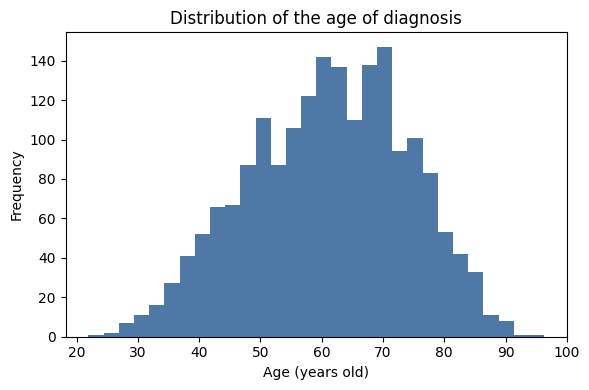

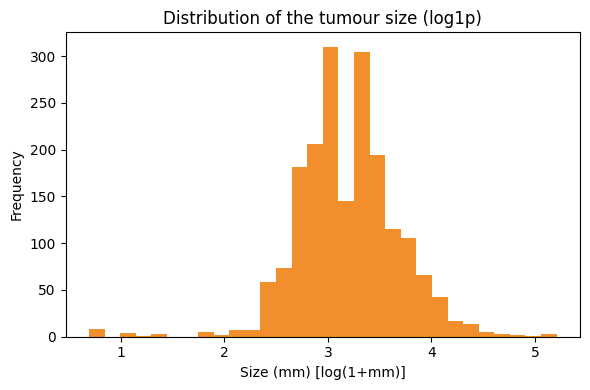

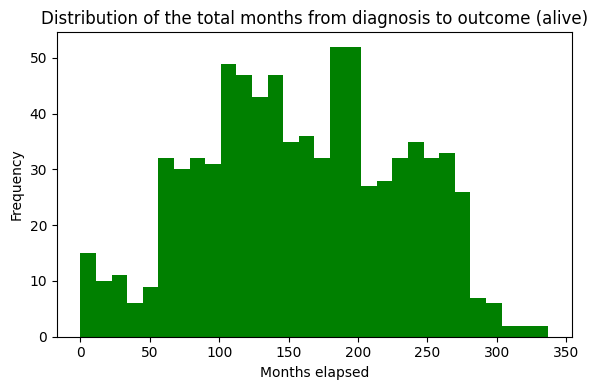

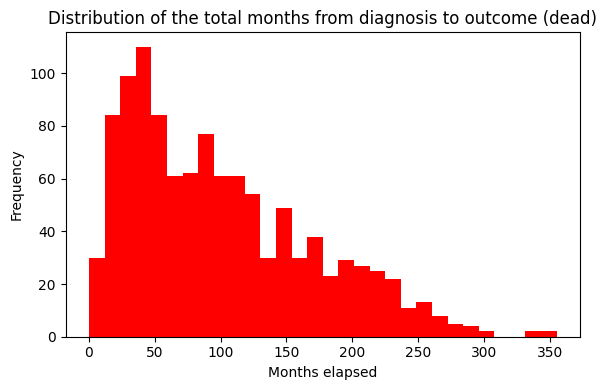

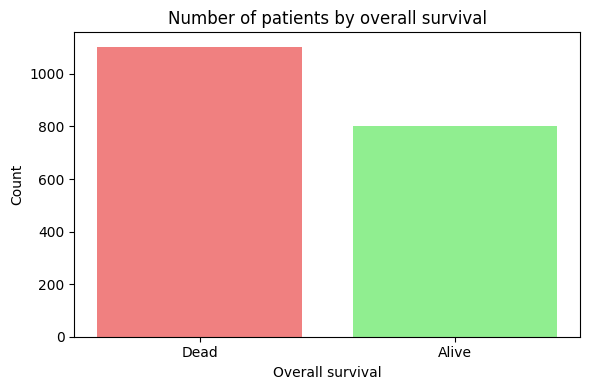

C:\Users\Enric Alavedra\AppData\Local\Temp\ipykernel_51652\1896094428.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cols, patch_artist=True)


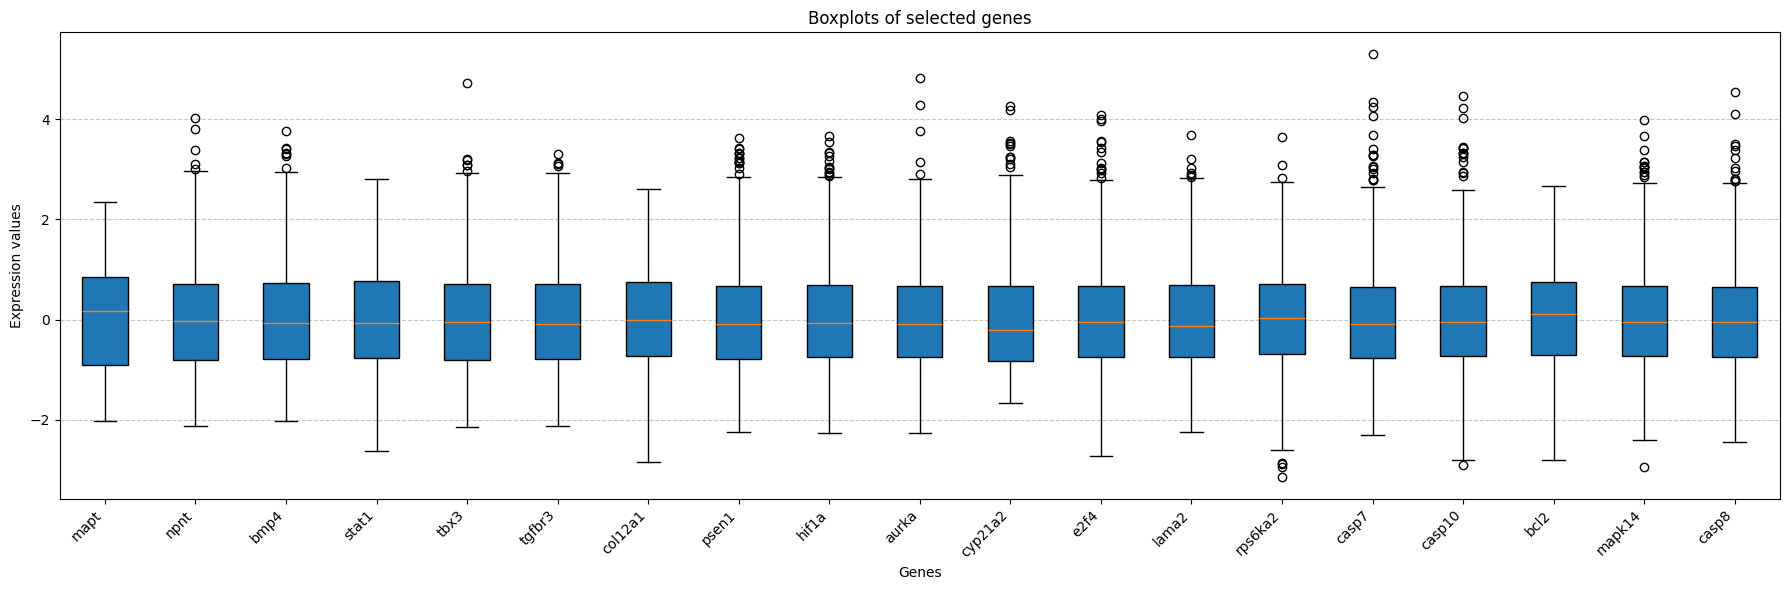

In [45]:
import matplotlib.pyplot as plt
# 1.  Distribution of the age of diagnosis
plt.figure(figsize=(6,4))
plt.hist(df_out["age_at_diagnosis"].dropna(), bins=30, color="#4e79a7")
plt.title("Distribution of the age of diagnosis")
plt.xlabel("Age (years old)")
plt.ylabel("Frequency")
plt.tight_layout()
#plt.savefig("figures/edad_hist.png", dpi=150)
# Este gráfico indica que la gran mayoría de las mujeres diagnosticadas con cáncer de mama son mujeres en edad post menopáusica (55-70 años). Se puede asumir una coherente distribución normal

# 2. Distribution of the tumor size 
tumor_size = df_out["tumor_size"].dropna().values
tumor_size_trans = np.log1p(tumor_size)
plt.figure(figsize=(6,4))
plt.hist(tumor_size_trans, bins=30, color="#f28e2b")
plt.title("Distribution of the tumour size (log1p)")
plt.xlabel("Size (mm) [log(1+mm)]")
plt.ylabel("Frequency")
plt.tight_layout()
#plt.savefig("figures/tamano_hist.png", dpi=150)
# Este gráfico muestra que el tamaño de los tumores no tiene una distirbución normal y quizá es bueno hacer una transformación (log-transform): hay mucho tumor entre 10 y 40mm, pero muchos outliers a más de 100mm

# 3. Distributions (alive vs dead) of months elapsed between diagnosis and clinical outcome
plt.figure(figsize=(6,4))
months_elapsed_alive = df_out[df_out["overall_survival"] == 1]["overall_survival_months"].dropna().values
months_elapsed_dead = df_out[df_out["overall_survival"] == 0]["overall_survival_months"].dropna().values
plt.hist(months_elapsed_alive, bins=30,color="#008000")
plt.title("Distribution of the total months from diagnosis to outcome (alive)")
plt.xlabel("Months elapsed")
plt.ylabel("Frequency")
plt.tight_layout()
plt.figure(figsize=(6,4))
plt.hist(months_elapsed_dead, bins=30, color="#FF0000")
plt.title("Distribution of the total months from diagnosis to outcome (dead)")
plt.xlabel("Months elapsed")
plt.ylabel("Frequency")
plt.tight_layout()

# 4. Count of patients alive and dead
counts = df_out.groupby("overall_survival").count()["age_at_diagnosis"]
labels = counts.index.map({0: "Dead", 1: "Alive"})
values = counts.values
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["#F08080", "#90EE90"]) 
plt.title("Number of patients by overall survival")
plt.ylabel("Count")
plt.xlabel("Overall survival")
plt.tight_layout()
plt.show()

# 5. Boxplot of distribution of the genes with highest variability
cols = ['mapt', 'npnt', 'bmp4', 'stat1', 'tbx3', 'tgfbr3', 'col12a1', 'psen1',
        'hif1a', 'aurka', 'cyp21a2', 'e2f4', 'lama2', 'rps6ka2', 'casp7', 
        'casp10', 'bcl2', 'mapk14', 'casp8']
data = [df_out[col].dropna() for col in cols]  
plt.figure(figsize=(18, 6))
plt.boxplot(data, labels=cols, patch_artist=True)
plt.title("Boxplots of selected genes")
plt.ylabel("Expression values")
plt.xlabel("Genes")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

###### Modelling with Logistic Regression (Binomial GLM) and Linear Regression ######

###### ¿Cuál es el objetivo de este primer estudio? ###### 
###### Se pretenden contestar dos preguntas diferentes: por una parte, ¿quién sobrevive (se va a resolver con un Modelo GLM Binomial)? y, por otra parte, ¿durante cuánto tiempo sobreviven (se resuelve con un Modelo LM Gaussiano)? ######
###### Sobre el primer punto, se pretende sacar conclusiones sobre la probabilidad de supervivencia de un paciente según un conjunto de variables clínicas (edad, tamaño tumoral, ganglios, terapias...) y variables moleculares (genes y mutaciones). A parte, se pretende identificar los factores asociados a mayor o menor supervivencia ######
###### Sobre el segundo punto, se pretende dar una intuición del número de meses promedio desde el diagnósitoc hasta el evento final (fallecimiento o cura). #######

In [66]:
# 1. Determination of a seed and target columns
seed = 42
y_alive  = df_out["overall_survival"] # I 1 means that patient is alive, if 0 means the patient is dead
y_months = df_out["overall_survival_months"]
X = df_out[feature_cols].copy()
print("### TARGET COLUMNS ###")
print("- Has the patient survived?")
print(y_alive.head())
print("- How long (months) has the survival lasts?")
print(y_months.head())
print("\n")

# 2. Separation of columns between numerical and categorical
numerical_features = df_out[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numerical_features]
print("### NUMERICAL COLUMNS ###")
print(numerical_features)
print("### CATEGORICAL COLUMNS ###")
print(categorical_features)
print("\n")
# las columnnas numéricas y categóricas transformadas son las que se usan en este modelo

# CAMBIO POST-PRIMERA EJECUCIÓN: la variable "tumor_size" no sigue una distribución normal. Una solución es aplicar una transformación de la columna
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
log1p_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
])
other_numerical_features = [c for c in numerical_features if c != "tumor_size"]

# 3. Preparation of the model using scikit-learn library
# 3.1. Split of the training and the test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_alive, y_test_alive = train_test_split(
    X, y_alive, test_size=0.25, random_state=seed, stratify=y_alive
)
_, _, y_train_months, y_test_months = train_test_split(
    X, y_months, test_size=0.25, random_state=seed
)
# 3.2. Preprocessing of the columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
numercial_columns_transform = Pipeline(steps=[("imp", SimpleImputer(strategy="median"))])
categorical_columns_transform = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
preprocessing = ColumnTransformer(
    transformers=[
        ("tumor_log1p", log1p_transformer, ["tumor_size"]),
        ("num", numercial_columns_transform, other_numerical_features),
        ("cat", categorical_columns_transform, categorical_features)
    ]
) 


### TARGET COLUMNS ###
- Has the patient survived?
0    1
1    1
2    0
3    1
4    0
Name: overall_survival, dtype: int64
- How long (months) has the survival lasts?
0    140.500000
1     84.633333
2    163.700000
3    164.933333
4     41.366667
Name: overall_survival_months, dtype: float64


### NUMERICAL COLUMNS ###
['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'patient_id', 'mapt', 'npnt', 'bmp4', 'stat1', 'tbx3', 'tgfbr3', 'col12a1', 'psen1', 'hif1a', 'aurka', 'cyp21a2', 'e2f4', 'lama2', 'rps6ka2', 'casp7', 'casp10', 'bcl2', 'mapk14', 'casp8', 'pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mu

In [67]:
# 3.3. Building the model and evaluation
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

# 3.3.1. Logistic Regressions (GLM)
# 3.3.1.1. Buiding the model
pipeline_GLM = Pipeline(steps=[("prep", preprocessing), ("clf", LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear"))]) # he puesto penalty para que suba AUC
# 3.3.1.2. Training the model with the training set
pipeline_GLM.fit(X_train, y_train_alive)
# 3.3.1.3. Making predictions with the model and evalutaing the prediction performance
probs = pipeline_GLM.predict_proba(X_test)[:, 1]
auc  = roc_auc_score(y_test_alive, probs)
fpr, tpr, _ = roc_curve(y_test_alive, probs)
print(f"AUC (overall_survival): {auc:.3f}") # El AUC da una idea de, teniendo un representante VIVO y uno FALLECIDO al azar, la probabilidad de asignar como mejor superviviente al VIVO 
# El resultado indica que el rendimiento es moderado, mejor que el azar, pero no es perfecto
# 3.3.1.4. Obtain the prediction function
clf = pipeline_GLM.named_steps["clf"]
coef = clf.coef_[0]
intercept = clf.intercept_[0]
print(intercept)
feature_names = pipeline_GLM.named_steps["prep"].get_feature_names_out()
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})
top15_coef = (
    coef_df
    .assign(abs_coef=lambda df: np.abs(df["coefficient"]))
    .sort_values("abs_coef", ascending=False)
    .head(15)
    .drop(columns="abs_coef")
)
display(top15_coef)

AUC (overall_survival): 0.731
4.675295190512289


,feature,coefficient
81,num__thsd7a_mut,-0.746958
129,cat__integrative_cluster_5,-0.739646
124,cat__integrative_cluster_10,0.687998
55,num__notch1_mut,-0.663103
121,cat__inferred_menopausal_state_Post,0.639656
87,num__fanca_mut,-0.606990
35,num__gata3_mut,0.606385
71,num__lamb3_mut,-0.583413
67,num__runx1_mut,-0.538272
128,cat__integrative_cluster_4ER-,0.535647


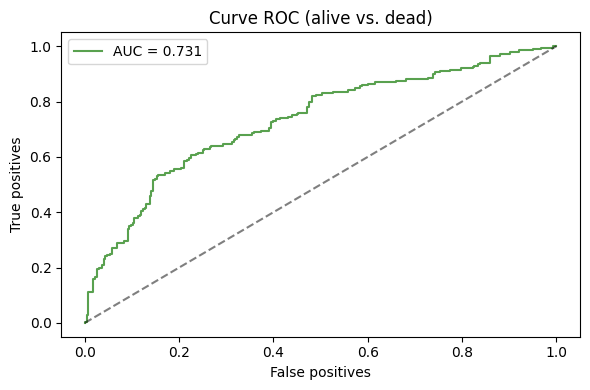

In [52]:
# 4. Figures of the results for visualization purposes
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="#59a14f", label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.title("Curve ROC (alive vs. dead)")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.legend()
plt.tight_layout()
#plt.savefig("figures/roc_alive.png", dpi=150)
# Como tenemos una curva ROC por encima de la diagonal, indica que el modelo tiene una capacidad predictiva aceptable 

In [ ]:
# 3.3.2. Linear Regression 
# 3.3.2.1. Division of the dataset betweeen patients alive and dead
mask_alive = y_alive == 1
mask_dead  = y_alive == 0
X_alive = X.loc[mask_alive].copy()
X_dead  = X.loc[mask_dead].copy()
y_months_alive = y_months.loc[mask_alive].copy()
y_months_dead  = y_months.loc[mask_dead].copy()
print("\n")
print("### SUMMARY OF DIVISION (alive vs dead) ###")
print(f"- Total rows: {len(df_out)}")
print(f"- Alive: {mask_alive.sum()}")
print(f"- Dead: {mask_dead.sum()}")
df_alive = df_out.loc[mask_alive].copy()
df_dead  = df_out.loc[mask_dead].copy()

from sklearn.model_selection import train_test_split
X_train_alive, X_test_alive, y_train_alive, y_test_alive = train_test_split(
    X_alive, y_months_alive, test_size=0.25, random_state=seed
)
X_train_dead, X_test_dead, y_train_dead, y_test_dead = train_test_split(
    X_dead, y_months_dead, test_size=0.25, random_state=seed
)

# 3.3.2.2. Building the model
pipe_lm_alive = Pipeline(steps=[("prep", preprocessing), ("lm", LinearRegression())])
pipe_lm_dead = Pipeline(steps=[("prep", preprocessing), ("lm", LinearRegression())])
# 3.3.2.3. Training the model with the training set
pipe_lm_alive.fit(X_train_alive, y_train_alive)
pipe_lm_dead.fit(X_train_dead, y_train_dead)
# 3.3.2.4. Making predictions with the model and evalutaing the prediction performance
pred_m_alive = pipe_lm_alive.predict(X_test_alive)
pred_m_dead = pipe_lm_dead.predict(X_test_dead)
rmse_alive   = np.sqrt(mean_squared_error(y_test_alive, pred_m_alive))
rmse_dead  = np.sqrt(mean_squared_error(y_test_dead, pred_m_dead))
print(f"RMSE (overall_survival_months for alive patients): {rmse_alive:.2f} meses")  
print(f"RMSE (overall_survival_months for dead patients): {rmse_dead:.2f} meses") 
# 3.3.2.5. Obtain the prediction function
# Alive patients
print("\n")
print("### FUNCTION FOR ALIVE PATIENTS ###")
lm_alive = pipe_lm_alive.named_steps["lm"]
coef_alive = lm_alive.coef_
intercept_alive = lm_alive.intercept_
print(intercept_alive)
feature_names = pipe_lm_alive.named_steps["prep"].get_feature_names_out()
coef_df_alive = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef_alive
})
top15_alive = (
    coef_df_alive
    .assign(abs_coef=lambda df: np.abs(df["coefficient"]))
    .sort_values("abs_coef", ascending=False)
    .head(15)
    .drop(columns="abs_coef")
)
print(top15_alive)
# Dead patients
print("\n")
print("### FUNCTION FOR DEAD PATIENTS ###")
lm_dead = pipe_lm_dead.named_steps["lm"]
coef_dead = lm_dead.coef_
intercept_dead = lm_dead.intercept_
print(intercept_dead)
feature_names = pipe_lm_dead.named_steps["prep"].get_feature_names_out()
coef_df_dead = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef_dead
})
top15_dead = (
    coef_df_dead
    .assign(abs_coef=lambda df: np.abs(df["coefficient"]))
    .sort_values("abs_coef", ascending=False)
    .head(15)
    .drop(columns="abs_coef")
)
print(top15_dead)




### SUMMARY OF DIVISION (alive vs dead) ###
- Total rows: 1904
- Alive: 801
- Dead: 1103
RMSE (overall_survival_months for alive patients): 75.22 meses
RMSE (overall_survival_months for dead patients): 62.03 meses


### FUNCTION FOR ALIVE PATIENTS ###
229.10338933395477
                        feature  coefficient
96              num__fancd2_mut    46.075543
69              num__map2k4_mut   -31.454692
76               num__ep300_mut   -29.114114
2             num__chemotherapy   -25.706126
57               num__ncor2_mut    23.419049
47               num__akap9_mut    23.077558
87               num__fanca_mut   -22.992246
85               num__myo1a_mut    22.698090
4          num__hormone_therapy   -22.088127
94                num__ctcf_mut    21.842179
48                  num__tg_mut    21.691079
130  cat__integrative_cluster_6    21.527224
52              num__col6a3_mut   -21.322517
73               num__erbb2_mut   -21.190131
79               num__setd2_mut    20.429493


### F

###### Classification Tree for survival prediction (FINALLY NOT ADDED TO THE REPORT) ######

In [ ]:
import numpy as np
import pandas as pd

# 1. Determination of a seed and target columns
seed = 42
y = df_out["overall_survival"]
X = df_out[feature_cols].copy()

# 2. Separation of columns between numerical and categorical
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numerical_features]

# 3. Preparation of the model using scikit-learn library
# 3.1. Split of the training and the test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed, stratify=y
)
# 3.2. Preprocessing of the columns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
numerical_columns_transform = Pipeline(steps=[("imp", SimpleImputer(strategy="median"))])
categorical_columns_transform = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preprocessing = ColumnTransformer(
    transformers=[
        ("num", numerical_columns_transform, numerical_features),
        ("cat", categorical_columns_transform, categorical_features)
    ]
)
# 3.3. Building the initial tree_classifier classifier and finding the best hyperparameters
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
tree_classifier = DecisionTreeClassifier(random_state=seed, class_weight="balanced")

param_grid = {
    "clf__max_depth": [3, 4, 5, 6, 8, 10],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 3, 5, 10],
    "clf__ccp_alpha": [0.0, 0.001, 0.005, 0.01]  # pruning
}

pipeline_Tree = Pipeline(steps=[("prep", preprocessing), ("clf", tree_classifier)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid = GridSearchCV(
    pipeline_Tree, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0
)
grid.fit(X_train, y_train)

print("Best hyperparameters:", grid.best_params_)
print(f"Best AUC-CV: {grid.best_score_:.3f}")
# 3.4. Evaluation of the model
best_model = grid.best_estimator_
probs_test = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, probs_test)
print(f"AUC test (árbol): {auc_test:.3f}")

Best hyperparameters: {'clf__ccp_alpha': 0.005, 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best AUC-CV: 0.730
AUC test (árbol): 0.723


###### Classification Tree using Gradient Boosting ######

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score,
                             brier_score_loss, confusion_matrix, classification_report)
from sklearn.calibration import CalibratedClassifierCV

from sklearn.experimental import enable_hist_gradient_boosting  # puede ser necesario en versiones antiguas
from sklearn.ensemble import HistGradientBoostingClassifier

# 1. Determination of a seed and target columns
seed = 42
y = df_out["overall_survival"]     
X = df_out[feature_cols].copy()

# 2. Separation of columns between numerical and categorical
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numerical_features]

# 3. Preparation of the model using scikit-learn library
# 3.1. Preprocessing of the columns
numerical_columns_transfrom = Pipeline(steps=[("imp", SimpleImputer(strategy="median"))])
categorical_columns_transform = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocesing = ColumnTransformer(transformers=[
    ("num", numerical_columns_transfrom, numerical_features),
    ("cat", categorical_columns_transform, categorical_features)
])
# 3.2. Building the Gradient Boosting classifier
hgb = HistGradientBoostingClassifier(
    loss="log_loss",               
    max_depth=None,               
    learning_rate=0.1,
    max_iter=300,                  
    l2_regularization=0.0,
    class_weight="balanced",      
    random_state=seed
)
pipeline_GB = Pipeline(steps=[("prep", preprocessing), ("clf", hgb)])
# 3.3. Separation of the dataset between training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed, stratify=y
)
# 3.4. Finding the best hyperparameters and training the model
param_grid = {
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_iter": [200, 300, 500],
    "clf__max_depth": [None, 3, 5, 7],
    "clf__l2_regularization": [0.0, 0.1, 1.0],
    "clf__min_samples_leaf": [20, 50, 100]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
grid = GridSearchCV(
    estimator=pipeline_GB,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)
print(f"Best AUC-CV: {grid.best_score_:.3f}")
# 3.5. Evaluation of the model with the testing set
best_model = grid.best_estimator_
probs_test = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, probs_test)
print(f"AUC test (HGB): {auc_test:.3f}")
# El modelo distingue razonablemente bien cuando se trata de un paciente VIVO o uno FALLECIDO. 

# 4. Figures of the results for visualization purposes
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="#1f77b4", label=f"AUC={auc_test:.3f}")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.title("ROC - HistGradientBoosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
# plt.savefig("figures/roc_hgb.png", dpi=150)
# Qué tipo de error es más común? El modelo tiene a predecir VIVO más a menudo, es decir, da FALSOS POSITIVOS (FP). Una matriz de confusión iría perfecto para ver esto mejor

prec, rec, _ = precision_recall_curve(y_test, probs_test)
ap = average_precision_score(y_test, probs_test)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, color="#d62728", label=f"AP={ap:.3f}")
plt.title("Precision-Recall - HistGradientBoosting")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
# plt.savefig("figures/pr_hgb.png", dpi=150)
print(f"PR-AUC (AP): {ap:.3f}") 
# Precision: es el porcentaje de pacientes predecidos como vivos y son realmente vivos entre el total de pacientes etiquetados como vivos.
# Recall: es el porcentaje de pacientes vivos que realmente el modelo identifica como pacientes vivos
# AP (Average Precision): rendimiento medio del clasificador a lo largo de toda la gama de umbrales. Para valorar si AP es bueno, se debe comparar con el baseline de PR (el porcentaje de pacientes vivos que hay)
prev = y_test.mean() 
print(f"Prevalencia (baseline PR): {prev:.3f}")  # Al tener un AP mayor podemos confirmar que se trata de un modelo de predicción bueno

# Calibración del modelo a partir del best_model encontrado (es decir, el mejor árbol encontrado)
# Isotonic: aplica una regresión isotónica, una función monótona que re-mapea las probabilidades crudas del modelo a probabilidades bien calibradas
# CV indica el número de pliegues dentro del conjunto de entrenamiento que usa la validación para la calibración
# Brier: error cuadrático medio entre la probabilidad predicha y el resultado observado (cuanto menor, mejor calibración básicamente)
calib = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calib.fit(X_train, y_train)
probs_cal = calib.predict_proba(X_test)[:, 1]
auc_cal   = roc_auc_score(y_test, probs_cal)
brier     = brier_score_loss(y_test, probs_cal)
print(f"AUC test (calibrado HGB): {auc_cal:.3f} | Brier: {brier:.3f}")

from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, probs_cal, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, "o-", color="#2ca02c", label="HGB calibrado")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.title("Calibration curve - HGB (isotónica)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
# plt.savefig("figures/calibration_hgb.png", dpi=150)
# Este gráfico de una idea de si es fiable o no el modelo calibrado: cuánto más cerca de la linea gris esten los puntos verdes, querrá decir que mejor predice el modelo. 



c:\Users\Enric Alavedra\Desktop\Documents Enric Alavedra\Altres\Master UPC\Q3\Models Lineals\Projecte Linear Models\venv\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
